In [1]:
using Distributions, TimeIt, PyPlot, JLD, ProgressMeter, CSV
include("/home/postdoc/dsen/Desktop/Biometrika-code/zz_structures.jl")
include("/home/postdoc/dsen/Desktop/Biometrika-code/mbsampler.jl")

get_clustering (generic function with 1 method)

In [2]:
data = CSV.read("/xtmp/PDMP_data/risk_factors_cervical_cancer.csv")
name = names(data);
predictors = vcat(Array(2:25), Array(27:28));

In [3]:
for i in predictors
    present = map(x->parse(Float64,x),data[name[i]][data[name[i]] .!= "?"])
    present_mean = mean(present)
    absent = data[name[i]] .== "?"
    data[name[i]][absent] = string(present_mean)
    data[name[i]] = map(x->parse(Float64,x),data[name[i]])     
    print(i, " ")
end 
y = Int64.(data[name[29]]);
data = Float64.(convert(Array, data));

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 27 28 

In [4]:
x = data[:,(sum(abs.(data),1) .!= 0)[1,:]];
X = sparse(x')
d, Nobs = size(X);
my_ll = ll_logistic_sp(X,y);
my_prior = gaussian_prior_nh(zeros(d),1*ones(d))
my_model = model(my_ll, my_prior)
σ02 = 1
root = find_root(my_model, rand(d));
gc()

In [5]:
β_0 = copy(root)
mb_size = 20

20

In [6]:
# Stratified sub-sampling without CV and with weights 

weights = sparse(abs.(X))
for i in 1:d 
    weights[i,:] /= sum(weights[i,:])
end

ll_pd_root_list = [partial_derivative_vec(my_model.ll, root, i, 1:Nobs) for i in 1:d]

cmbsamplers = Array{mbsampler}(d)
N_cluster = mb_size

for dim in 1:d
    
    N_cluster_d = min(N_cluster, length(ll_pd_root_list[dim].nzval))
    csamplers = Array{mbsampler}(N_cluster_d)
    
    clusters = get_clustering(N_cluster_d, ll_pd_root_list[dim].nzval)
    for i in 1:N_cluster_d
        clusters[i] =  ll_pd_root_list[dim].nzind[clusters[i]]
    end
    #print(clusters)
    scp = ones(N_cluster_d)
    for (ci, c) in enumerate(clusters)
        csamplers[ci] = wumbsampler(size(c)[1], scp[ci], weights[dim,c])
    end
    cmbsamplers[dim] = spcmbsampler(csamplers, clusters, weights[dim,:])
end
gs_list_SS = mbsampler_list(d,cmbsamplers);

#### Run algorithms:

In [7]:
A = eye(d)
opf = projopf(A, 100)
opt = maxa_opt(5*10^7)
adapt_speed = "none"
L = 2;

In [8]:
mstate_SS = zz_state(d);
bb_ll_SS = build_bound(my_model.ll, gs_list_SS)
bb_pr_SS = build_bound(my_model.pr)
update_bound(bb_pr_SS, my_model.pr, mstate_SS)
update_bound(bb_ll_SS, my_model.ll, mstate_SS, gs_list_SS)
outp_SS = outputscheduler(deepcopy(opf),deepcopy(opt))

my_zz_sampler_SS = zz_sampler_decoupled(0, gs_list_SS, bb_pr_SS, bb_ll_SS, L, adapt_speed)
ZZ_sample_decoupled(my_model, outp_SS, my_zz_sampler_SS, mstate_SS)

filename  = "/xtmp/PDMP_data_revision/cervical_cancer/SS.jld"
save(filename, "xt_skeleton", outp_SS.opf.xi_skeleton, "bt_skeleton", outp_SS.opf.bt_skeleton)

10% attempts in 12.42 mins 
20% attempts in 25.14 mins 
30% attempts in 36.53 mins 
40% attempts in 47.46 mins 
50% attempts in 58.74 mins 
60% attempts in 69.91 mins 
70% attempts in 81.27 mins 
80% attempts in 92.53 mins 
90% attempts in 103.54 mins 
100% attempts in 114.33 mins 


In [16]:
discard, n_samples = 0, 10^4
xi_samples_noCV = extract_samples(outp_noCV.opf.xi_skeleton[:,discard+1:end], 
                             outp_noCV.opf.bt_skeleton[:,discard+1:end], 
                        (outp_noCV.opf.bt_skeleton[end]-outp_noCV.opf.bt_skeleton[discard+1])/n_samples,
                             "linear")
xi_samples_CV = extract_samples(outp_CV.opf.xi_skeleton[:,discard+1:end], 
                             outp_CV.opf.bt_skeleton[:,discard+1:end], 
                        (outp_CV.opf.bt_skeleton[end]-outp_CV.opf.bt_skeleton[discard+1])/n_samples,
                             "linear")
xi_samples_wt_noCV = extract_samples(outp_wt_noCV.opf.xi_skeleton[:,discard+1:end], 
                             outp_wt_noCV.opf.bt_skeleton[:,discard+1:end], 
                        (outp_wt_noCV.opf.bt_skeleton[end]-outp_wt_noCV.opf.bt_skeleton[discard+1])/n_samples,
                             "linear")
xi_samples_wt_CV = extract_samples(outp_wt_CV.opf.xi_skeleton[:,discard+1:end], 
                             outp_wt_CV.opf.bt_skeleton[:,discard+1:end], 
                        (outp_wt_CV.opf.bt_skeleton[end]-outp_wt_CV.opf.bt_skeleton[discard+1])/n_samples,
                             "linear")
xi_samples_ss = extract_samples(outp_ss.opf.xi_skeleton[:,discard+1:end], 
                             outp_ss.opf.bt_skeleton[:,discard+1:end], 
                        (outp_ss.opf.bt_skeleton[end]-outp_ss.opf.bt_skeleton[discard+1])/n_samples,
                             "linear");

LoadError: [91mInexactError()[39m

In [17]:
maxlag = 5000
acfs = zeros(5, d, maxlag+1)
for dim in 1:d 
    acfs[1,dim,:] = acf(xi_samples_noCV[dim,:], maxlag)
    acfs[2,dim,:] = acf(xi_samples_CV[dim,:], maxlag)
    acfs[3,dim,:] = acf(xi_samples_wt_noCV[dim,:], maxlag)
    acfs[4,dim,:] = acf(xi_samples_wt_CV[dim,:], maxlag)
    acfs[5,dim,:] = acf(xi_samples_ss[dim,:], maxlag)
end

LoadError: [91mUndefVarError: xi_samples_wt_noCV not defined[39m

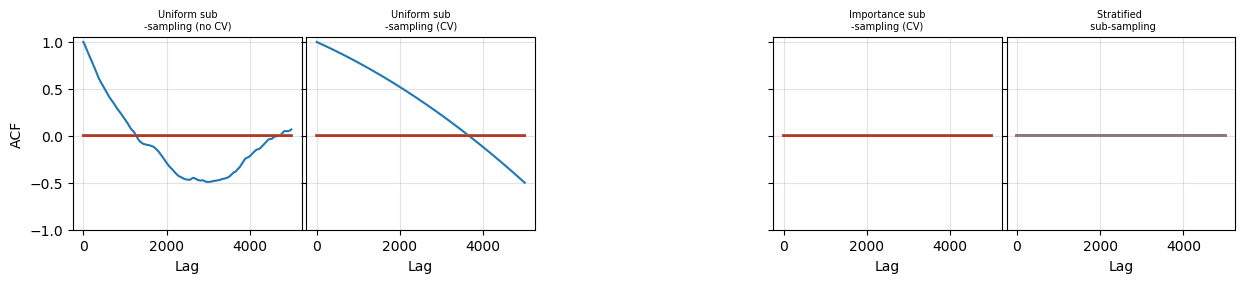

In [18]:
using PyPlot
fig = figure("pyplot_subplot_mixed", figsize=(15,2.5))

a, b = -1, 1.05

subplot(151)
for i in 1:d plot(acfs[1,i,:]) end
grid(alpha=0.35)
xlabel("Lag", fontsize=10)
ylabel("ACF", fontsize=10)
ylim([a,b])
title("Uniform sub\n-sampling (no CV)", fontsize=7)

subplot(152)
for i in 1:d plot(acfs[2,i,:]) end
grid(alpha=0.35)
xlabel("Lag", fontsize=10)
ylim([a,b])
yticks(alpha=0)
title("Uniform sub\n-sampling (CV)", fontsize=7)

subplot(155)
for i in 1:d plot(acfs[3,i,:]) end
grid(alpha=0.35)
xlabel("Lag", fontsize=10)
ylabel("ACF", fontsize=10)
ylim([a,b])
title("Importance sub\n-sampling (no CV)", fontsize=7)

subplot(154)
for i in 1:d plot(acfs[4,i,:]) end
grid(alpha=0.35)
xlabel("Lag", fontsize=10)
ylim([a,b])
yticks(alpha=0)
title("Importance sub\n-sampling (CV)", fontsize=7)

subplot(155)
for i in 1:d plot(acfs[5,i,:]) end
grid(alpha=0.35)
xlabel("Lag", fontsize=10)
yticks(alpha=0)
ylim([a,b])
title("Stratified \n sub-sampling", fontsize=7)
subplots_adjust(wspace=0.02)

In [36]:
ml = zeros(maxlag)
for i in 1:maxlag 
    ml[i] = mean(sum(acfs[1,:,1:i],2))/mean(sum(acfs[3,:,1:i],2))
end

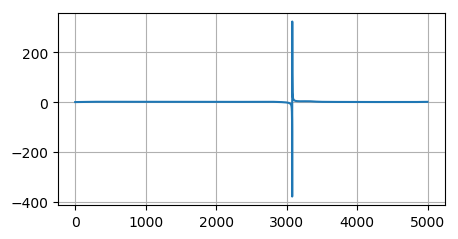

In [48]:
fig = figure("pyplot_subplot_mixed", figsize=(5,2.5))
plot(ml)
grid(true);

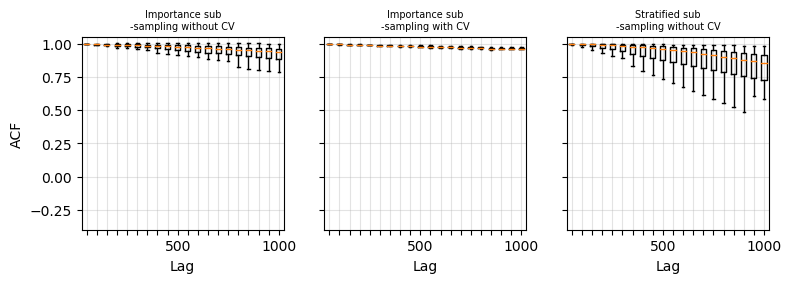

PyObject Text(0.5, 1.0, 'Stratified sub\n-sampling without CV')

In [23]:
using PyPlot
fig = figure("pyplot_subplot_mixed", figsize=(12,2.5))

a, b = -0.4, 1.05
subplot(141)
boxplot(acfs_wt_noCV, showfliers=false)
grid(alpha=0.35)
xlabel("Lag", fontsize=10)
ylabel("ACF", fontsize=10)
xticks(1:Int(maxlag/plot_freq), xt)
ylim([a,b])
title("Importance sub\n-sampling without CV", fontsize=7)

subplot(142)
boxplot(acfs_wt_CV, showfliers=false)
grid(alpha=0.35)
xlabel("Lag", fontsize=10)
xticks(1:Int(maxlag/plot_freq), xt)
ylim([a,b])
yticks(alpha=0)
title("Importance sub\n-sampling with CV", fontsize=7)

subplot(143)
boxplot(acfs_ss, showfliers=false)
grid(alpha=0.35)
xlabel("Lag", fontsize=10)
xticks(1:Int(maxlag/plot_freq), xt)
yticks(alpha=0)
ylim([a,b])
title("Stratified sub\n-sampling without CV", fontsize=7)

In [36]:
B = 100
print(round(minimum(compute_ESS(outp_wt_noCV.opf, B))), "\n")
print(round(minimum(compute_ESS(outp_wt_CV.opf, B))), "\n")
print(round(minimum(compute_ESS(outp_wt_noCV_ss.opf, B))), "\n")
print(round(minimum(compute_ESS(outp_wt_CV_ss.opf, B))), "\n")

203.0
113.0
363.0
108.0


In [37]:
print(round(mean(compute_ESS(outp_wt_noCV.opf, B))), "\n")
print(round(mean(compute_ESS(outp_wt_CV.opf, B))), "\n")
print(round(mean(compute_ESS(outp_wt_noCV_ss.opf, B))), "\n")
print(round(mean(compute_ESS(outp_wt_CV_ss.opf, B))), "\n")

28759.0
23353.0
59399.0
16355.0
